In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#sites = ['ADHD1',
#        'ADHD3',
#        'ADHD5',
#        'ADHD6',
#        'HSJ',
#        'Svip1',
#        'Svip2',
#        'SZ3',
#        'SZ6',
#        'UCLA_CB',
#        'UCLA_DS1',
#        'UKBB11025',
#        'UKBB11026',
#        'UKBB11027']

# Order by n in site
sites = ['SZ3',
        'SZ6',
        'Svip2',
        'ADHD6',
        'HSJ',
        'UCLA_CB',
        'Svip1',
        'UKBB11026',
        'UKBB11027',
        'UKBB11025',
        'ADHD1',
        'ADHD3',
        'ADHD5',
        'UCLA_DS1']

#p_sex = './results/sex/'
p_sex = './results_paper/sex/'

In [3]:
"""
nsite = {'ABIDEII-BNI_1': 6,
 'ABIDEII-ETH_1': 23,
 'ABIDEII-GU_1': 26,
 'ABIDEII-IP_1': 7,
 'ABIDEII-IU_1': 3,
 'ABIDEII-KKI_1': 17,
 'ABIDEII-NYU_1': 27,
 'ABIDEII-OHSU_1': 27,
 'ABIDEII-OILH_2': 13,
 'ABIDEII-SDSU_1': 21,
 'ABIDEII-SU_2': 7,
 'ABIDEII-TCD_1': 18,
 'ABIDEII-UCD_1': 10,
 'ABIDEII-UCLA_1': 9,
 'ABIDEII-USM_1': 13,
 'ABIDEII-U_MIA_1': 10,
 'ADHD1': 54,
 'ADHD3': 56,
 'ADHD4': 14,
 'ADHD5': 77,
 'ADHD6': 39,
 'Cardiff': 8,
 'HSJ': 39,
 'KKI': 22,
 'LEUVEN_1': 5,
 'MAX_MUN': 11,
 'NYU': 66,
 'OLIN': 8,
 'SDSU': 13,
 'SZ1': 42,
 'SZ10': 9,
 'SZ2': 41,
 'SZ3': 31,
 'SZ4': 25,
 'SZ5': 17,
 'SZ6': 35,
 'SZ7': 14,
 'SZ8': 14,
 'SZ9': 14,
 'Svip1': 48,
 'Svip2': 36,
 'TRINITY': 25,
 'UCLA_1': 24,
 'UCLA_2': 5,
 'UCLA_CB': 43,
 'UCLA_DS1': 94,
 'UCLA_DS2': 19,
 'UKBB11025': 1000,
 'UKBB11026': 1000,
 'UKBB11027': 1000,
 'UM_1': 10,
 'USM': 30,
 'YALE': 15}
"""
# for paper UKBB cap at 50
nsite = {'ABIDEII-BNI_1': 6,
 'ABIDEII-ETH_1': 23,
 'ABIDEII-GU_1': 26,
 'ABIDEII-IP_1': 7,
 'ABIDEII-IU_1': 3,
 'ABIDEII-KKI_1': 17,
 'ABIDEII-NYU_1': 27,
 'ABIDEII-OHSU_1': 27,
 'ABIDEII-OILH_2': 13,
 'ABIDEII-SDSU_1': 21,
 'ABIDEII-SU_2': 7,
 'ABIDEII-TCD_1': 18,
 'ABIDEII-UCD_1': 10,
 'ABIDEII-UCLA_1': 9,
 'ABIDEII-USM_1': 13,
 'ABIDEII-U_MIA_1': 10,
 'ADHD1': 54,
 'ADHD3': 56,
 'ADHD4': 14,
 'ADHD5': 77,
 'ADHD6': 39,
 'Cardiff': 8,
 'HSJ': 39,
 'KKI': 22,
 'LEUVEN_1': 5,
 'MAX_MUN': 11,
 'NYU': 66,
 'OLIN': 8,
 'SDSU': 13,
 'SZ1': 42,
 'SZ10': 9,
 'SZ2': 41,
 'SZ3': 31,
 'SZ4': 25,
 'SZ5': 17,
 'SZ6': 35,
 'SZ7': 14,
 'SZ8': 14,
 'SZ9': 14,
 'Svip1': 48,
 'Svip2': 36,
 'TRINITY': 25,
 'UCLA_1': 24,
 'UCLA_2': 5,
 'UCLA_CB': 43,
 'UCLA_DS1': 94,
 'UCLA_DS2': 19,
 'UKBB11025': 50,
 'UKBB11026': 50,
 'UKBB11027': 50,
 'UM_1': 10,
 'USM': 30,
 'YALE': 15}

# Load Data

In [4]:
# Single Task
st_data = []
for site in sites:
    folds = []
    for fold in range(5):
        p_parent = os.path.join(p_sex, f"{site}/fold_{fold}")
        file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
        folds.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1])[site])
    st_data.append(folds)

st_data = dict(zip(sites,st_data))

In [5]:
# Multi-task
mtl_data = []
for fold in range(5):
    p_parent = os.path.join(p_sex, f"all/fold_{fold}")
    file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
    mtl_data.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1]))


# Get Accuracy

In [6]:
# Single Task
st_acc = []
st_acc_std = []
for site in sites:
    # Connectomes
    vals = [st_data[site][fold]['Accuracy/test'].iloc[-1] for fold in range(5)]
    st_acc.append(np.mean(vals))
    st_acc_std.append(np.std(vals))

st_acc = pd.Series(st_acc,index=sites)
st_acc_std = pd.Series(st_acc_std,index=sites)

In [7]:
# Multi-task
mtl_acc = []
for fold in range(5):
    df = mtl_data[fold].transpose().reset_index()
    df = df[df['level_1']=='Accuracy/test'].set_index('level_0')[99]
    mtl_acc.append(df)
    
mtl_acc_std = pd.concat(mtl_acc,axis=1).std(axis=1)
mtl_acc = pd.concat(mtl_acc,axis=1).mean(axis=1)

# Tables

In [8]:
df = pd.concat([st_acc,mtl_acc,st_acc_std,mtl_acc_std],axis=1)
df.columns = ['ST','MTL','ST_std','MTL_std']
df['diff'] = df['MTL'] - df['ST']
df

,ST,MTL,ST_std,MTL_std,diff
SZ3,42.857143,40.000000,0.000000e+00,6.388766,-2.857143
SZ6,57.142857,65.714286,7.105427e-15,12.777531,8.571429
Svip2,60.000000,72.500000,5.000000e+00,10.458250,12.500000
ADHD6,70.000000,70.000000,6.123724e+00,11.180340,0.000000
HSJ,60.000000,57.500000,5.000000e+00,11.180340,-2.500000
UCLA_CB,33.333333,44.444444,0.000000e+00,13.608276,11.111111
Svip1,60.000000,62.000000,0.000000e+00,13.038405,2.000000
UKBB11026,62.000000,72.000000,7.483315e+00,4.472136,10.000000
UKBB11027,68.000000,68.000000,4.000000e+00,4.472136,0.000000
UKBB11025,52.000000,88.000000,4.000000e+00,8.366600,36.000000


In [9]:
df.mean()

ST         57.986472
MTL        63.686007
ST_std      3.015770
MTL_std     8.779760
diff        5.699536
dtype: float64

# Plots

In [10]:
lenmax = 25
site_labels = []
for site in sites:
    n = f'{nsite[site]}'
    nspaces = lenmax - 2*len(site) - len(n)
    label = site.upper()+(' '*nspaces)+f'n={n}'
    site_labels.append(label)
    print(f"'{label}',")

'SZ3                 n=31',
'SZ6                 n=35',
'SVIP2             n=36',
'ADHD6             n=39',
'HSJ                 n=39',
'UCLA_CB         n=43',
'SVIP1             n=48',
'UKBB11026     n=50',
'UKBB11027     n=50',
'UKBB11025     n=50',
'ADHD1             n=54',
'ADHD3             n=56',
'ADHD5             n=77',
'UCLA_DS1       n=94',


In [11]:
#site_labels = [
#'SZ3                   n=31',
#'SZ6                   n=35',
#'SVIP2               n=36',
#'ADHD6             n=39',
#'HSJ                   n=39',
#'UCLA_CB         n=43',
#'SVIP1               n=48',
#'ADHD1             n=54',
#'ADHD3             n=56',
#'ADHD5             n=77',
#'UCLA_DS1       n=94',
#'UKBB11026   n=1000',
#'UKBB11027   n=1000',
#'UKBB11025   n=1000']

site_labels = [
'SZ3                 n=31',
'SZ6                 n=35',
'SVIP2             n=36',
'ADHD6           n=39',
'HSJ                 n=39',
'UCLA_CB       n=43',
'SVIP1             n=48',
'UKBB11026    n=50',
'UKBB11027    n=50',
'UKBB11025    n=50',
'ADHD1           n=54',
'ADHD3           n=56',
'ADHD5           n=77',
'UCLA_DS1     n=94']

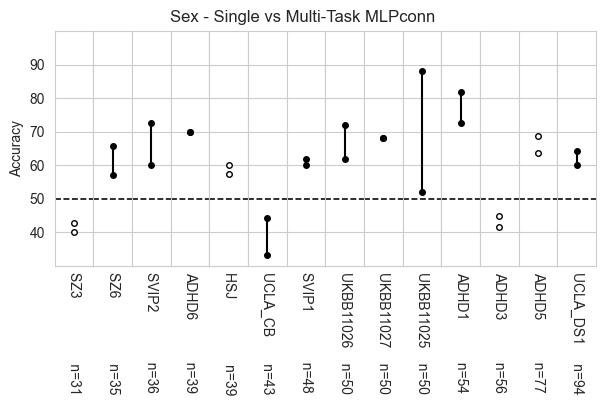

In [15]:
###############
# CONNECTOMES #
###############
title = 'Sex - Single vs Multi-Task MLPconn'
fig,ax = plt.subplots(1,len(sites),figsize=(6,4),sharey=True,sharex=True)
plt.yticks([40,50,60,70,80,90])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,site in enumerate(sites):
    st_acc = df.loc[site]['ST']
    mtl_acc = df.loc[site]['MTL']
    if st_acc > mtl_acc:
        mfc = 'white'
        ls =''
    else:
        mfc = colors[0]
        ls = '-'

    ax[j].plot(5,mtl_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot(5,st_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot((5,5),(st_acc,mtl_acc),color=colors[0],ls=ls)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(site_labels[j],rotation=270)

    lines = ax[j].get_ygridlines()
    b = lines[1]
    b.set_color('black')
    b.set_linewidth(1.15)
    b.set_linestyle('--')

ax[0].set_ylabel('Accuracy')
plt.suptitle(title)
plt.ylim(30,100)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join(p_sex,'figures/st_vs_mtl.png'),dpi=300)